### **ANN Streamflow Prediction**

*_Author: Aline Van Driessche_*

This notebook contains all code needed to reproduce the ANN expansion training results on individual catchments (meteorological inputs available from Era5, measurement precipitation and groundtruth streamflow from the NRFA). Read section headings for more details on setup, preprocessing, and model training.

#### Setup

Importing relevant modules and custom scripts. A number of helper functions are also defined to clean up experiment code.

In [87]:
import os
import paths
import random
import torch
import warnings

import utils as ut
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdt

from tqdm import tqdm
from matplotlib import gridspec
from apollo import metrics as me
from apollo import mechanics as ma
from train_model import load_data, train
from train_model import sensitivity_analysis as sa
from preprocessing import visualisation
from preprocessing import catchment_characteristics as cc

warnings.filterwarnings('ignore')

In [88]:
def process_hourly_data(hourly_df):

    #hourly_df = hourly_df.rename(columns={'date': 'Date'})
    hourly_df['Date'] = pd.to_datetime(hourly_df['Date'], format='%Y-%m-%d').dt.date

    # 2-HOURLY INPUT
    for i in range(1, 25, 2):
        col_name = f'Rain_{i//2}_2hourly'
        hourly_df[col_name] = hourly_df[f"Rain_-{i}"] + hourly_df[f"Rain_-{i+1}"]

    # ROLLING MEANS OVER TIME WINDOWS
    hourly_df['Rain_2h_mean'] = hourly_df.rolling(window=2, axis=1).mean().iloc[1:, -1]
    hourly_df['Rain_4h_mean'] = hourly_df.rolling(window=4, axis=1).mean().iloc[1:, -1]
    hourly_df['Rain_6h_mean'] = hourly_df.rolling(window=6, axis=1).mean().iloc[1:, -1]

    # PARAMETRISATION
    hourly_df['Delta_y'] =  hourly_df.apply(lambda row: (row.iloc[1:].max() - row[[f"Rain_-{i+1}" for i in range(24)]].sum()/24), axis=1)
    hourly_df['Delta_x'] = hourly_df.apply(lambda row: (24 - int(row.iloc[1:].idxmax().split('_')[1]))/24, axis=1)
    return hourly_df

In [89]:
def retrieve_sensitivity(station_nr, sensitivity_degree, feature):
    
    sf_station = pd.read_csv('../' + paths.PREDICTIONS + f"/{input_type}/{station_nr}_{input_type}_sensitivity_rain.csv")
    sf_feature = sf_station[sf_station['Variable'] == feature]
    return sf_feature[sensitivity_degree].iloc[0]

def plot_sensitivities(ax, sorted_results, sort_by, sensitivity_degree, labels_names, legend=True):
    labels_added = {feature: False for feature in labels_names}
    latitude_labels = [round(value, 2) for value in sorted_results[sort_by]]
    
    for index, row in sorted_results.iterrows():
        for i, feature in enumerate(features):
            color = colors[i % len(colors)]
            x_offset = (i - 3) * bar_width  # Adjust the x position to avoid overlap

            label = labels_names[i] if not labels_added[labels_names[i]] else ""
            labels_added[labels_names[i]] = True

            ax.vlines(x=index + x_offset, ymin=0, ymax=retrieve_sensitivity(row['Station'], sensitivity_degree=sensitivity_degree, feature=feature), colors=color, linestyles='solid', label=label)
    
    ax.set_xticks(range(len(latitude_labels)))
    ax.set_xticklabels(latitude_labels, rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylabel('Sensitivity', fontweight='bold', fontsize=12)
    if legend is True:
        ax.legend(loc='upper left', fontsize=12)

### Experiment Variables

All variables that could be modified during the experiments. The features refer to the type of input variables that will be used for training and how many days in the past are included.

In [90]:
station = 7001

days = 6
features = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] 
            + ['Temperature'] + ['Temperature-' + f'{d+1}' for d in range(days)] \
            + ['Resultant Windspeed'] + ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            + ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)]\
            #+ ['Soil Moisture ' + f'{i+1}' for i in range(4)])
            + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']) 

years_train = [1981 + i for i in range(30)]
years_eval = [2010 + i for i in range(10)]

input_type = '9to9_HR_surf_interp' #others: {'linear', '9to9_cubic', '9to9_surf_interp' ...}

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Loading and Processing Relevant Data

Data loading function that extracts and preprocesses the data as defined in the “Experiment Variables” section and returns the in- and output for training. The initial catchment information (shapefile catchment boundary etc) are downloaded from the *https://nrfa.ceh.ac.uk/* website. For reproduction, also the river streamflow can be obtained from the *https://nrfa.ceh.ac.uk/* website, and the meteorological input variables through the Coopernicus CDS API, *https://cds.climate.copernicus.eu/*. The input variables are preprocessed in the correct manner after running 'assembly.py'. 

In [91]:
# General information
general_info_df = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_gdf.csv'))
catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))

In [92]:
# In- and output variables
original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + f"_lumped_{input_type}.csv"))
original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
clean_data = original_data.dropna(subset=['Flow'])
print(len(original_data) - len(clean_data), 'riverflow values are missing.')

0 riverflow values are missing.


#### Running Experiments

Data is extracted and preprocessed as defined in the "Experiment Variables" section. We use a neural network training using the hyperparameters as described above. The paper outlines which metrics generate the best performances for each latitude. Our three metrics (RMSE, NSE, RE) are then calculated.

In [93]:
def train_NN(rf, years_train, years_eval, features=features, loss_func=None, alpha=1.0, beta=1.0, grid_search=False, early_stopping=True, verbose=True, network_params={}):

    # LOAD DATA
    trnset, full_set = load_data.preprocess_data(rf, features, years_eval, years_train)
    targets = ['Flow']
    xspace = ma.featurelocator(rf, features)
    yspace = ma.featurelocator(rf, targets)

    x_train = load_data.reshape_input(trnset, xspace)
    y_train = load_data.reshape_output(trnset, yspace)   
    
    psi = ut.psi_distribution(y_train, 'lognorm', alpha=alpha, beta=beta, plot=False)
    
    # TRAINING
    network = train.train(x_train, 
                          y_train,
                          verbose=verbose, 
                          loss_func_type=loss_func, 
                          psi=psi[:len(x_train)], 
                          grid_search=grid_search, 
                          early_stopping=early_stopping,
                          network_params=network_params)

    # EVALUATION
    x_eval = load_data.reshape_input(full_set, xspace)  
    y_eval = load_data.reshape_input(full_set, yspace)  
    
    rf.loc[:, 'Predicted'] = network.predict(torch.from_numpy(x_eval).to(device))
    rf.loc[:, 'Groundtruth'] = y_eval    
    rf['Date'] =  pd.to_datetime(rf['Date'], unit='s')
    rf = rf[rf['Date'].dt.year.isin(years_train + years_eval)]
    rf.reset_index(drop=True, inplace=True)
    return rf, network

#### Sensitivity Analysis Daily Precipitation

This section shows how to calculate and plot the sensitivity to a certain (set) of features. Here performed for all the various catchment and plotted on an x-axis with ascending latitudes.

In [83]:
## MODEL TRAINING + PREDICTIONS + SAVE SENSITIVITIES

proxies = ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] 
sf_summary = pd.DataFrame(index=proxies)

for station_nr in tqdm(os.listdir('../' + paths.CATCHMENT_BASINS)[11:], desc="Processing Stations"):
    
    out_path = '../' + paths.PREDICTIONS + f"/{input_type}/{station_nr}_{input_type}.csv"
    out_path_sens = '../' + paths.PREDICTIONS + f"/{input_type}/{station_nr}_{input_type}_sensitivity_rain.csv"
    
    if not os.path.exists(out_path_sens):
        catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(station_nr) + '.shp')
    
        original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(station_nr) + f"_lumped_{input_type}.csv")
        original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
        subset = ['Flow'] + ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu']
        clean_data = original_data.dropna(subset=subset)
        print(len(clean_data))
    
        outdf, network = train_NN(rf=clean_data, years_train=years_train, years_eval=years_eval, features=features, loss_func=None, alpha=1,  beta=2, grid_search=False, verbose=False)
        outdf.to_csv(out_path)
        
        sf = sa.perform_sensitivity_analysis(network, features, outdf, proxies)
        sf.to_csv(out_path_sens)

Processing Stations: 100%|██████████| 15/15 [00:00<00:00, 14990.36it/s]


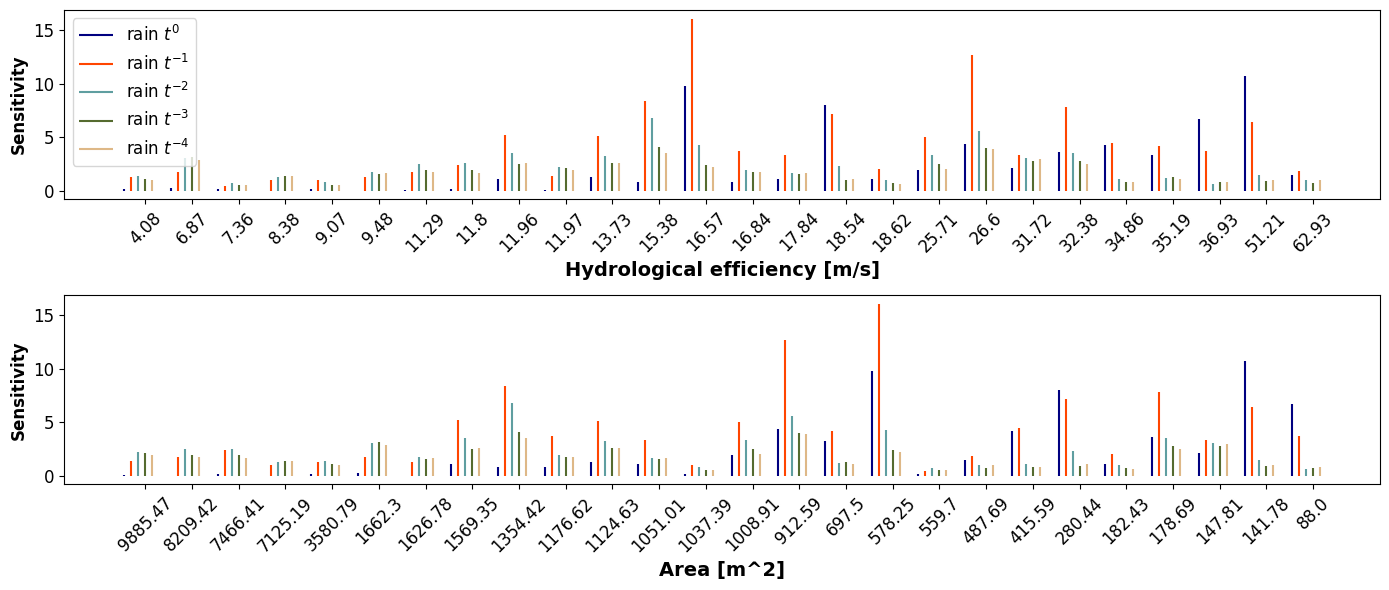

In [51]:
bar_width = 0.15
sensitivity_degree = '+1.0'
features = ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days-2)] 
feature_labels = [r'rain $t^{0}$', r'rain $t^{-1}$', r'rain $t^{-2}$', r'rain $t^{-3}$', r'rain $t^{-4}$', r'rain $t^{-5}$']
colors = ['navy', 'orangered', 'cadetblue', 'darkolivegreen', 'BurlyWood']

combined_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS)

# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))

sorted_by_latitude = combined_gdf.sort_values(by='HE_mean').reset_index(drop=True)
plot_sensitivities(ax1, sorted_by_latitude, 'HE_mean', sensitivity_degree, labels_names=feature_labels)
ax1.set_xlabel('Hydrological efficiency [m/s]', fontweight='bold', size=14)

combined_gdf['Area'] = combined_gdf['Area'] / 10**6
sorted_by_area = combined_gdf.sort_values(by='Area', ascending=False).reset_index(drop=True)
plot_sensitivities(ax2, sorted_by_area, 'Area', sensitivity_degree, labels_names=feature_labels, legend=False)
ax2.set_xlabel('Area [m^2]', fontweight='bold', size=14)

plt.tight_layout()
plt.savefig(f"{paths.IMAGES}/rain_sensitivity_{sensitivity_degree}.png", dpi=300, bbox_inches='tight')
plt.show()

#### Experiment 1: Higher Temporal Resolution

Expand the standard NN by incorporating hourly data in various ways. The hourly data is process and stored as *'stationNumber_daily_rain_9to9_linear.csv'* when running the 'assembly.py' script.

In [69]:
station = 54057
original_hourly_df = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + f"/{station}_hourly_rain_9to9_linear.csv")
clean_hourly_data = process_hourly_data(original_hourly_df)
clean_data['Date'] = pd.to_datetime(clean_data['Date'], format='%Y-%m-%d').dt.date

combined_data = pd.merge(clean_data, clean_hourly_data, on='Date')
combined_data = combined_data.dropna()

In [70]:
# Sanity check to see if the hourly values are correctly calibrated with the daily ones (24 hours sum should be equal)
combined_data['Daily_Sum'] = combined_data[ [f"Rain_-{i+1}" for i in range(24)]].sum(axis=1)
combined_data[['Date', 'Rain', 'Daily_Sum']].head()

,Date,Rain,Daily_Sum
0,1986-02-10,-0.081980,0.003524
1,1986-02-11,-0.081774,0.208925
2,1986-02-12,-0.081970,0.040557
3,1986-02-13,-0.073861,0.031734
4,1986-02-14,-0.073319,0.803872


In [105]:
import importlib
importlib.reload(visualisation)

<module 'preprocessing.visualisation' from 'C:\\Users\\aline\\soil-moisture-proxies\\preprocessing\\visualisation.py'>

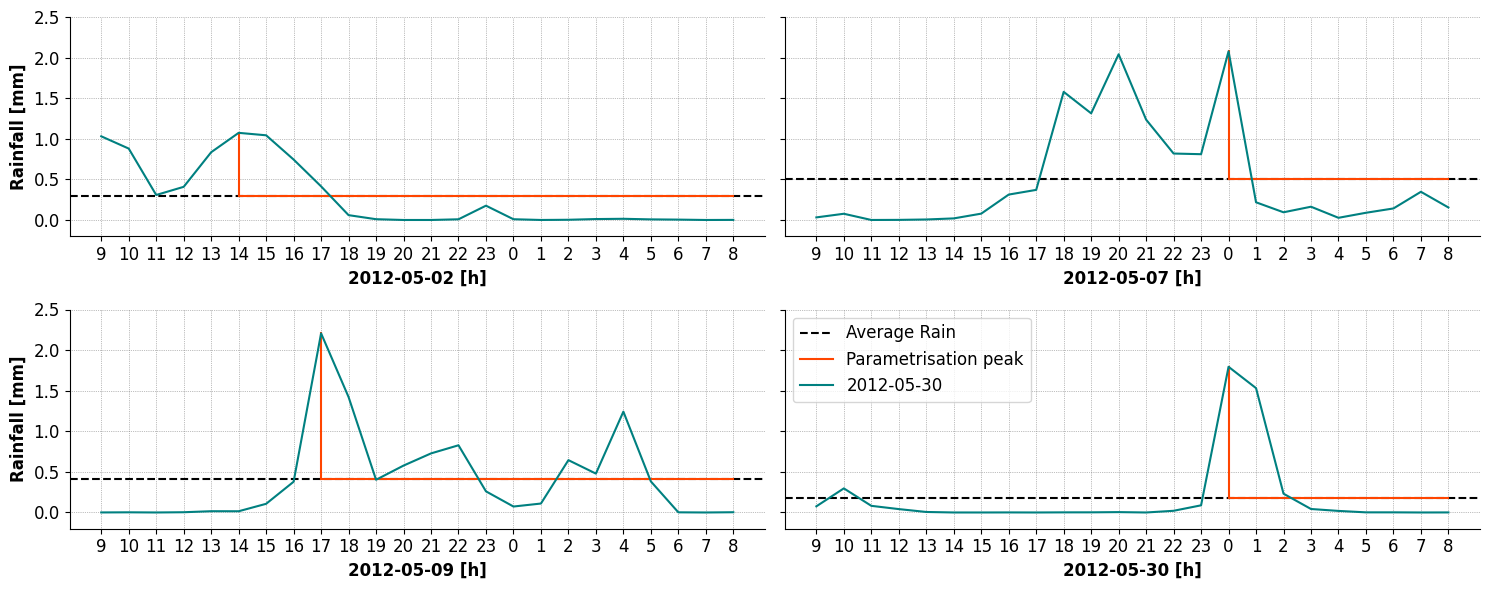

In [106]:
# Plot the hourly parameterisation for the peak value for some random days 
year = 2012
month = 5
random_days = [1,6,8,29]

save_path = f"{paths.IMAGES}/hourly_rainfall_{year}_{month}.png"
visualisation.plot_hourly_rainfall(combined_data.copy(), year, month, random_days, save_path)

epoch 0, loss 164.52236938476562
epoch 500, loss 49.998619079589844
epoch 1000, loss 47.78786849975586
epoch 1500, loss 47.069427490234375
epoch 2000, loss 46.7108039855957
epoch 2500, loss 46.43882751464844
epoch 3000, loss 46.09859085083008
epoch 3500, loss 45.712772369384766
epoch 4000, loss 45.43305206298828
epoch 4500, loss 45.227508544921875
epoch 5000, loss 45.11702346801758
epoch 5500, loss 45.08985137939453
Early stopping at epoch 5771, best validation loss: 41.72895050048828


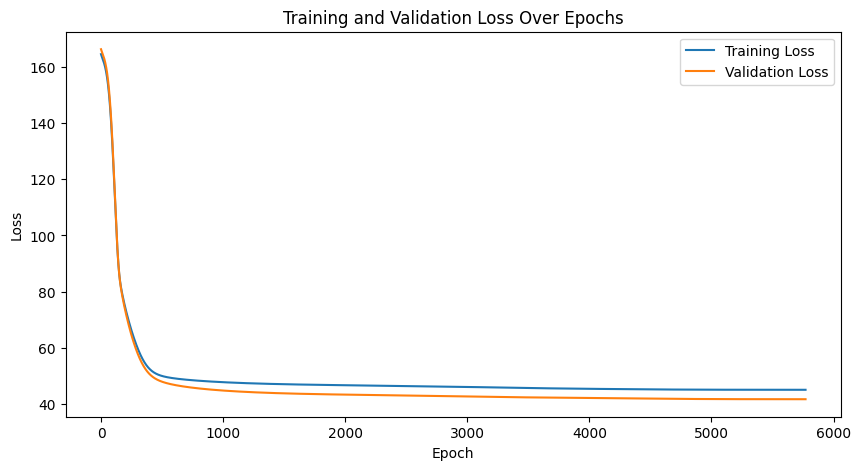

In [75]:
hourly_feature_options = {'24 hours datapoints (24)':[f"Rain_-{i+1}" for i in range(24)],
                          '2 hourly datapoints (12)':[f'Rain_{i//2}_2hourly' for i in range(0, 24, 2)], 
                          '2-4-6 hours rolling means (3)':['Rain_2h_mean', 'Rain_4h_mean', 'Rain_6h_mean'],
                          'Peak parametrisation (2)': ['Delta_y'] + ['Delta_x']}

expanded_features = features + hourly_feature_options.get('Peak parametrisation (2)')
network_params = {'learning_rate': 0.001, 
                  'hidden_size': 64, 
                  'dropout_rate': 0.8, 
                  'weight_decay': 0.2}

outdf, network = train_NN(rf=combined_data.copy(), 
                          years_train=years_train, 
                          years_eval=years_eval, 
                          features=expanded_features, 
                          loss_func=None,
                          alpha=1, 
                          beta=2, 
                          grid_search=False,
                          verbose=True, 
                          network_params=network_params) 

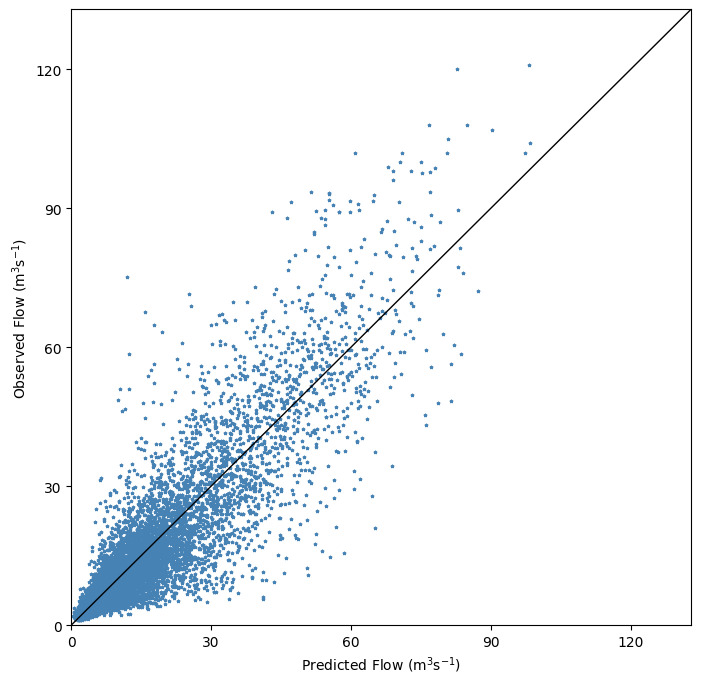

RMSE: 6.169314183475717
NSE: 0.8007120339782909
RE: 0.9323415822764359


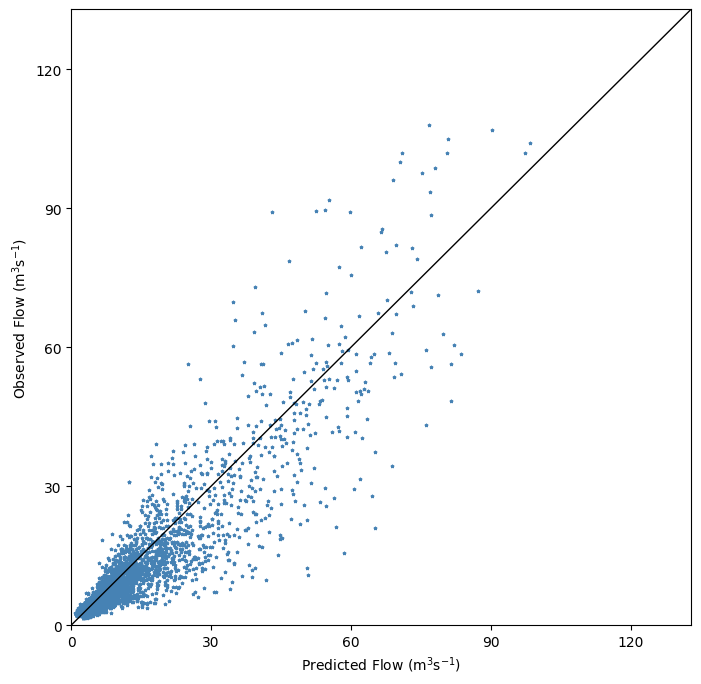

RMSE: 6.131671282790266
NSE: 0.7905183313964638
RE: 0.9215828825160722


In [175]:
# Plot the network performance
for test_period in (years_train+years_eval, years_eval):
     
    performance_dict = train.calculate_performance_metrics(outdf, test_period) 

    print('RMSE: ' + str(performance_dict.get('RMSE')))
    print('NSE: ' + str(performance_dict.get('NSE')))
    print('RE: ' + str(performance_dict.get('RE')))

#### Experiment 2: Including Snow Melt Data

Adding snow melt as an extra input parameter to the model (also with the 7 previous days). The snow melt data is process and stored in a similar way as the precipitation (aggregation, interpolation) when running the 'assembly.py' script.

In [107]:
importlib.reload(visualisation)

<module 'preprocessing.visualisation' from 'C:\\Users\\aline\\soil-moisture-proxies\\preprocessing\\visualisation.py'>

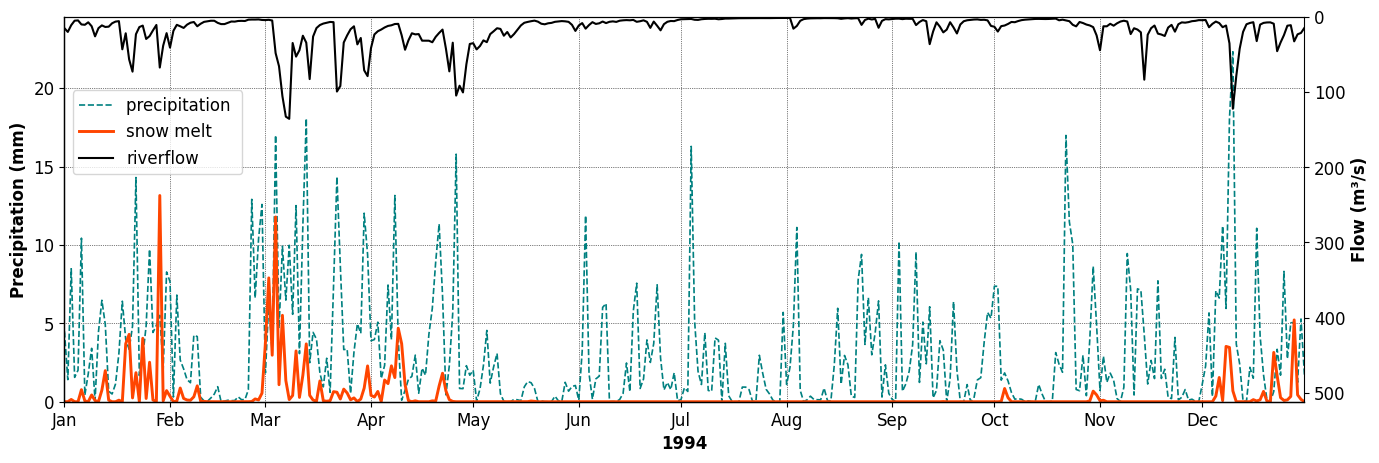

In [108]:
clean_data['Date'] = pd.to_datetime(clean_data['Date'], format='%Y-%m-%d')
visualisation.compare_precipitation_and_flow(year=1994, 
                                             dfs_precipitation=[clean_data], 
                                             colors=['Teal'], 
                                             labels=[''],
                                             plot_snow=True,
                                             df_separate=clean_data,
                                             label_separate='Flow',
                                             save_path=f"{paths.IMAGES}/snowmelt_vs_precipitation.png")

epoch 0, loss 586.4242553710938
epoch 500, loss 165.15794372558594
epoch 1000, loss 147.55032348632812
epoch 1500, loss 124.47889709472656
epoch 2000, loss 114.5577163696289
epoch 2500, loss 110.10405731201172
epoch 3000, loss 107.8967514038086
Early stopping at epoch 3286, best validation loss: 111.20951080322266


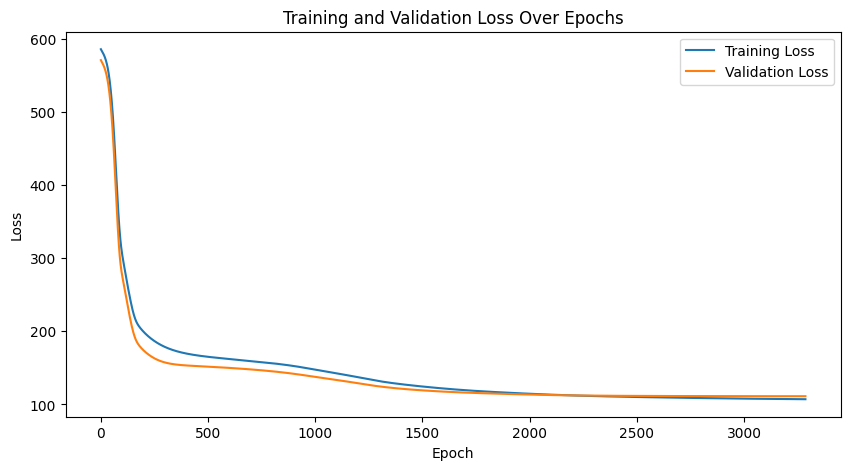

In [101]:
expanded_features = features + ['Snow Melt'] + ['Snow Melt-' + f'{d+1}' for d in range(days)] 

network_params = {'learning_rate': 0.001, 
                  'hidden_size': 128, 
                  'dropout_rate': 0.0, 
                  'weight_decay': 0.2}

outdf, network = train_NN(rf=clean_data.copy(), 
                          years_train=years_train, 
                          years_eval=years_eval, 
                          features=expanded_features, 
                          loss_func=None,
                          alpha=1, 
                          beta=1, 
                          grid_search=False,
                          network_params=network_params,
                          verbose=True) 

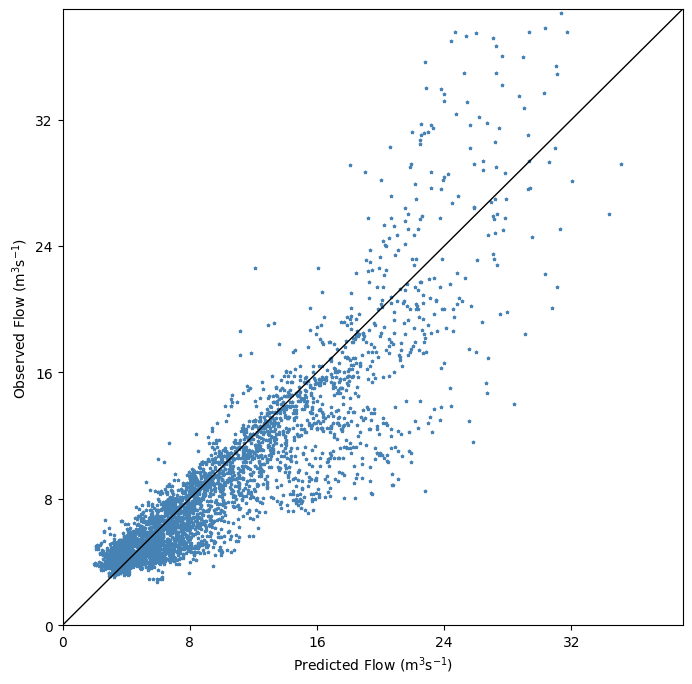

RMSE: 2.9011154756197004
NSE: 0.7731560663647624
RE: 0.835050353188781


In [487]:
# Plot the network performance
for test_period in ([years_eval]):
     
    performance_dict = train.calculate_performance_metrics(outdf, test_period) 

    print('RMSE: ' + str(performance_dict.get('RMSE')))
    print('NSE: ' + str(performance_dict.get('NSE')))
    print('RE: ' + str(performance_dict.get('RE')))

#### Experiment 2

Calculate the mean performance metrics on the 3 individual catchments based on a k-fold cross-validation. Training is similar as before, except that the training/test split is carried out randomly instead of based on fixed (chronological) periods of time.

In [468]:
total_years = [1980 + i for i in range(40)]
k_folds = 5

In [469]:
performance_metrics = []
for i in tqdm(range(k_folds), desc="K-Fold Progress"):
    
    years_eval = random.sample(total_years, 10)
    years_train = [year for year in total_years if year not in years_eval]
    
    outdf = train_NN(rf=clean_data.copy(), years_train=years_train, years_eval=years_eval, features=features, loss_func=None,alpha=1, beta=2, grid_search=False,verbose=False) 
    
    performance_dict = train.calculate_performance_metrics(outdf, years_eval, plot=False) 
    performance_metrics.append(performance_dict)
    
performance_df = pd.DataFrame(performance_metrics)
mean_performance = performance_df.mean()
mean_performance

K-Fold Progress: 100%|██████████| 5/5 [06:03<00:00, 72.67s/it]


RMSE    49.215488
NSE      0.816639
RE       0.925629
dtype: float64

#### Experiment 3

Expand across 25 other UK catchments. The descriptions for all these catchments are defined in 'Catchment_Database.csv', where station number, station name, flow file, boundary file ... are defined per catchment. All this information has been retrieved from the *https://nrfa.ceh.ac.uk/* website. The model predictions are stored for each catchment individually. Based on these performances, the NSE for each catchment is calculated, as a comparative metric. Other catchment characteristics (hydrological efficiency, slope gradient, latitude ..) are deduced from the previously obtained data (flow & geographical boundaries) from NRFA. These characteristics are then used to plot the correlation with the model performance in each catchment.

In [14]:
## MODEL TRAINING + PREDICTIONS

input_type = '9to9_HR_surf_interp'
days = 6

for station_nr in tqdm(os.listdir('../' + paths.CATCHMENT_BASINS), desc="Processing Stations"):
    
    out_path = '../' + paths.PREDICTIONS + f"/{input_type}_Snow/{station_nr}_{input_type}_Snow.csv"
    
    if not os.path.exists(out_path):
        catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(station_nr) + '.shp')
        print('processing')
    
        original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(station_nr) + f"_lumped_{input_type}.csv")
        original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
        subset = ['Flow'] + ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu']
        clean_data = original_data.dropna(subset=subset)
        print(len(clean_data))
        expanded_features = features + ['Snow Melt'] + ['Snow Melt-' + f'{d+1}' for d in range(days)]
    
        outdf, network = train_NN(rf=clean_data, years_train=years_train, years_eval=years_eval, features=expanded_features, loss_func=None, alpha=1, beta=2, grid_search=False, verbose=False)
        outdf.to_csv(out_path)

Processing Stations: 100%|██████████| 26/26 [00:00<00:00, 13032.02it/s]
